# Prompt Trajectories + Specificity Visualizations

Reads `data/prompt_trajectories.csv` + `data/session_summary.csv` and plots:
- heatmap of intent over time
- specificity trajectory
- constraint trajectory
- distributions


In [1]:
import sys
sys.executable


'c:\\Users\\Ali\\Downloads\\ConvoKit\\prompt_analysis_v2\\.venv\\Scripts\\python.exe'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
traj = pd.read_csv('../data/prompt_trajectories.csv')
summary = pd.read_csv('../data/session_summary.csv')
traj.head(), summary.head()

(           conversation_id  timestep        prompt_intent  meta_cognitive  \
 0  legislation_corporate_1         0                other           False   
 1  legislation_corporate_1         1   explain_or_clarify           False   
 2  legislation_corporate_1         2  delegation_generate           False   
 3  legislation_corporate_1         3  delegation_generate           False   
 4  legislation_corporate_1         4   explain_or_clarify           False   
 
    hedging  certainty  authority_transfer  refinement  prompt_length  \
 0    False      False               False       False              9   
 1    False      False               False       False             30   
 2    False      False               False       False              5   
 3    False      False               False       False             18   
 4    False      False               False       False             10   
 
    num_constraints_rule  descriptive_words    t_norm  specificity_pred  
 0              

## 1) Intent heatmap
Each row = session, columns = normalized timestep bins. Values = most common intent in that bin.


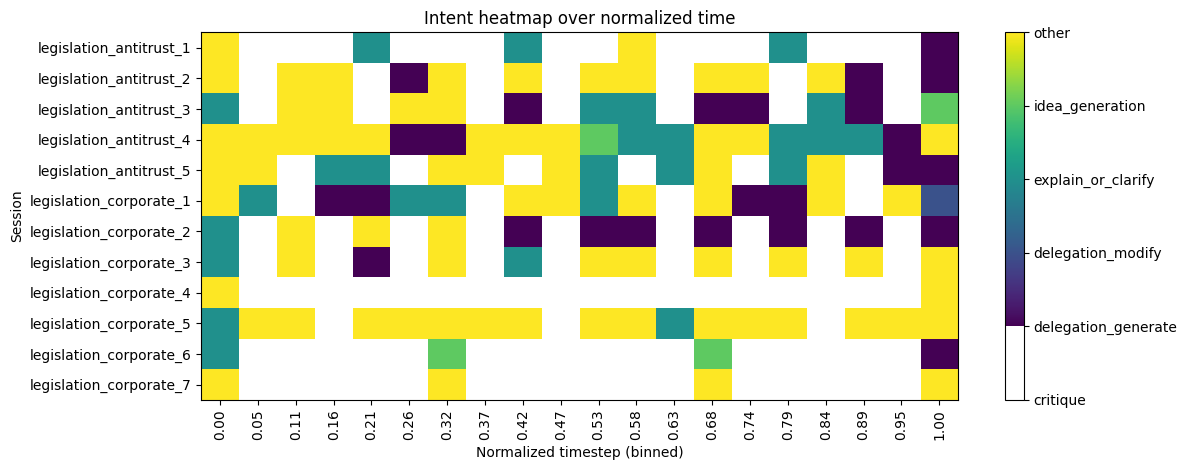

In [4]:
intent_to_id = {k:i for i,k in enumerate(sorted(traj['prompt_intent'].unique()))}
id_to_intent = {v:k for k,v in intent_to_id.items()}

# bin by t_norm into 20 bins
bins = 20
traj['bin'] = (traj['t_norm'] * (bins-1)).round().astype(int)

sessions = sorted(traj['conversation_id'].unique())
mat = np.full((len(sessions), bins), np.nan)

for r, sid in enumerate(sessions):
    sub = traj[traj['conversation_id']==sid]
    for b in range(bins):
        subb = sub[sub['bin']==b]
        if len(subb)==0:
            continue
        # majority intent
        top_intent = subb['prompt_intent'].value_counts().idxmax()
        mat[r,b] = intent_to_id[top_intent]

plt.figure(figsize=(12, max(3, len(sessions)*0.4)))
im = plt.imshow(mat, aspect='auto')
cbar = plt.colorbar(im)
cbar.set_ticks(list(id_to_intent.keys()))
cbar.set_ticklabels([id_to_intent[i] for i in id_to_intent.keys()])
plt.yticks(range(len(sessions)), sessions)
plt.xticks(range(bins), [f"{i/(bins-1):.2f}" for i in range(bins)], rotation=90)
plt.title('Intent heatmap over normalized time')
plt.xlabel('Normalized timestep (binned)')
plt.ylabel('Session')
plt.tight_layout()
plt.show()

## 2) Specificity trajectory
`specificity_pred` is the sklearn score (continuous). If it’s missing, run `learn_prompt_specificity.py`.

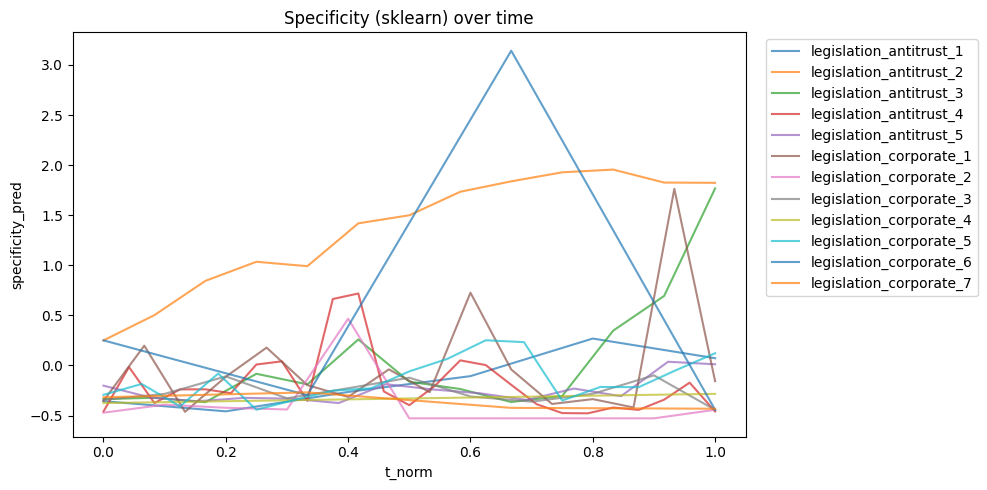

In [5]:
plt.figure(figsize=(10,5))
for sid in sessions:
    sub = traj[traj['conversation_id']==sid].sort_values('timestep')
    if sub['specificity_pred'].notna().any():
        plt.plot(sub['t_norm'], sub['specificity_pred'], alpha=0.7, label=sid)
plt.title('Specificity (sklearn) over time')
plt.xlabel('t_norm')
plt.ylabel('specificity_pred')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3) Constraints + descriptive words trajectory
Rule-based counts (baseline).

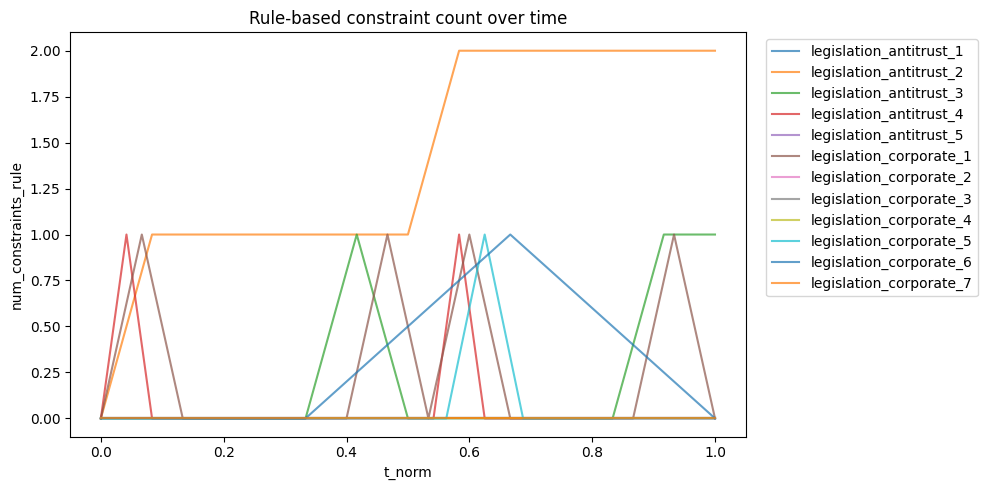

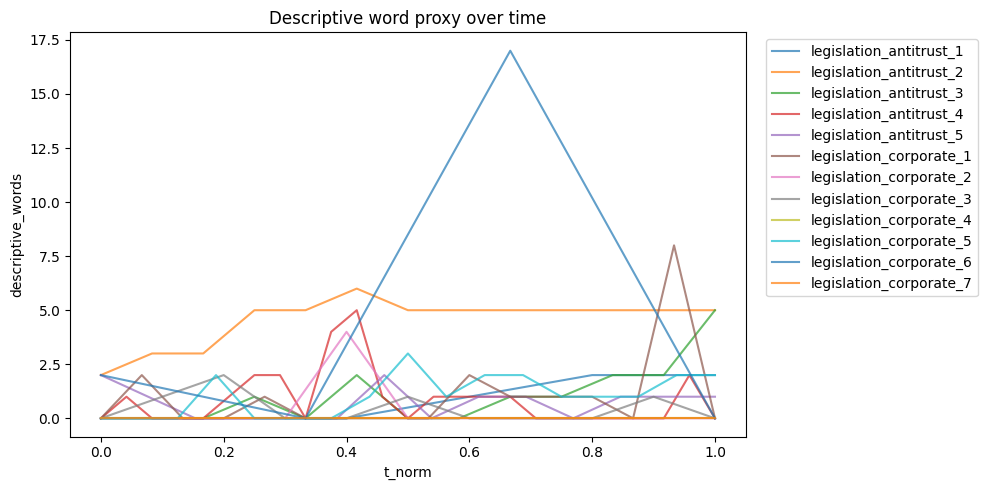

In [6]:
plt.figure(figsize=(10,5))
for sid in sessions:
    sub = traj[traj['conversation_id']==sid].sort_values('timestep')
    plt.plot(sub['t_norm'], sub['num_constraints_rule'], alpha=0.7, label=sid)
plt.title('Rule-based constraint count over time')
plt.xlabel('t_norm')
plt.ylabel('num_constraints_rule')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
for sid in sessions:
    sub = traj[traj['conversation_id']==sid].sort_values('timestep')
    plt.plot(sub['t_norm'], sub['descriptive_words'], alpha=0.7, label=sid)
plt.title('Descriptive word proxy over time')
plt.xlabel('t_norm')
plt.ylabel('descriptive_words')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4) Distributions
Check whether the signals are too sparse.

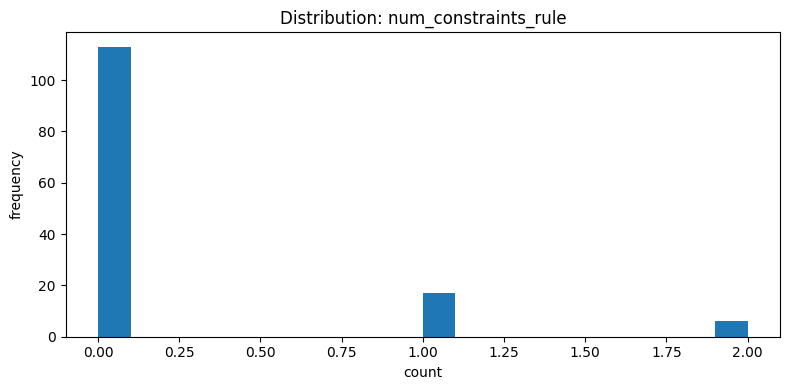

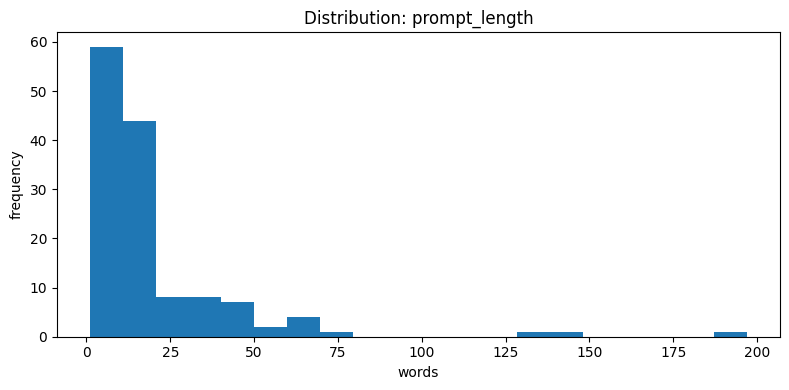

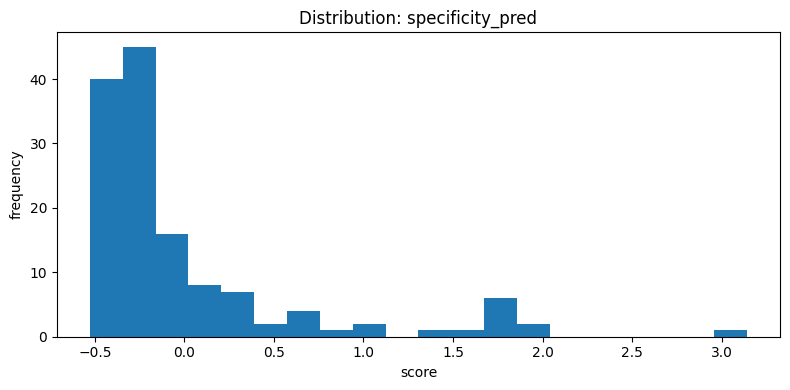

In [7]:
plt.figure(figsize=(8,4))
plt.hist(traj['num_constraints_rule'], bins=20)
plt.title('Distribution: num_constraints_rule')
plt.xlabel('count')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(traj['prompt_length'], bins=20)
plt.title('Distribution: prompt_length')
plt.xlabel('words')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

if traj['specificity_pred'].notna().any():
    plt.figure(figsize=(8,4))
    plt.hist(traj['specificity_pred'].dropna(), bins=20)
    plt.title('Distribution: specificity_pred')
    plt.xlabel('score')
    plt.ylabel('frequency')
    plt.tight_layout()
    plt.show()

In [2]:
import pandas as pd
import numpy as np
import spacy

traj = pd.read_csv("../data/prompt_trajectories.csv")
assert "text" in traj.columns, "Add raw prompt text into prompt_trajectories.csv as 'text'."

nlp = spacy.load("en_core_web_sm")  # python -m spacy download en_core_web_sm

def syntactic_features(text: str):
    doc = nlp(text or "")
    tokens = [t for t in doc if not t.is_space]
    n = max(len(tokens), 1)

    pos_counts = {}
    for t in tokens:
        pos_counts[t.pos_] = pos_counts.get(t.pos_, 0) + 1

    dep_counts = {}
    for t in tokens:
        dep_counts[t.dep_] = dep_counts.get(t.dep_, 0) + 1

    # A simple “syntactic specificity” score (transparent + defensible):
    # weighted density of modifiers + entities + numeric constraints + negation markers
    adj_rate = pos_counts.get("ADJ", 0) / n
    noun_rate = (pos_counts.get("NOUN", 0) + pos_counts.get("PROPN", 0)) / n
    num_rate = pos_counts.get("NUM", 0) / n
    neg_rate = dep_counts.get("neg", 0) / n

    spec_score = (1.5 * adj_rate) + (1.0 * noun_rate) + (2.0 * num_rate) + (1.0 * neg_rate)

    return {
        "tok_n": n,
        "adj_rate": adj_rate,
        "noun_rate": noun_rate,
        "num_rate": num_rate,
        "neg_rate": neg_rate,
        "syntactic_specificity": spec_score
    }

feat_df = traj["text"].fillna("").apply(syntactic_features).apply(pd.Series)
traj2 = pd.concat([traj, feat_df], axis=1)

traj2[["conversation_id","timestep","syntactic_specificity","adj_rate","num_rate","neg_rate"]].head()


AssertionError: Add raw prompt text into prompt_trajectories.csv as 'text'.